# 7.party_prediction

Here we implement the code for calculating average marginal effects (AME) of unigrams and bigrams in the document-term-matrix presented in section 7. The AME of each unigram/bigram $k$ and party $j$ is calculated as

$$
AME_{jk} = \frac{\partial Pr[y_i = j|\mathbf{w}_{i}]}{\partial w_{jk}} = N^{-1} \sum_{i = 1}^N p_{ij}\left(\theta_{jk} - \sum^J_{m = 1} p_{im} \theta_{mk}\right)
$$

using the predicted probabilities and coefficients given by ```scikit-learns``` multinomial logit. The speed could be massively improved using numpy vectorization but we have not been able to make that work yet. For that reason estimating confidence intervals through bootstraping is probably not feasible. This might however, not be very informative either way for reasons explained in the exam text.

In [1]:
#Necessary packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
#Read the data bushfire subset
data = pd.read_csv("data/bushfire_subset.csv")

In [3]:
class MlogitMargins:
    """
    Calculates marginal effect of multinomial logit coefficients with bootstraped confidence interval.
    See https://github.com/alicehwu/gendered_language/blob/master/gendered_language_2018.pdf for a 
    reference on a similar approach but with binary classification.
    """
    def __init__(self, X, y, penalty):
        
        #Define data
        self.vect = CountVectorizer(ngram_range=(1,1), max_features = 10000)
        self.X = self.vect.fit_transform(X)
        self.y = y
        self.penalty = penalty
        print("Fitting model and calculating margins...")
        
        self.margins, self.fitted_model = self.avg_margins(self.X, self.y, self.penalty)
    
    def avg_margins(self, X, y, penalty):
        """
        Calculates average marginal effect of coefficients in multinomial logit model, where each coefficient is 
        a word token and is calculated as:
        avg_margin_jk =  1/N * sum_i{sum{P(y_i = j) * [beta_jk - sum_m(P(y_i = m) 
                         * beta_jm)]} for each token k and class j.
        -----------
        Returns:
            - DataFrame with average margins of shape classes_j * tokens_k
            - The fitted mlogit model 
        """
        #Fit the model
        model = self.fit_model(X, y, penalty)
        #Get probabilities for each obs i belonging to class j. shape =  N * J
        probas = model.predict_proba(X)
        #Get coefficients. Shape j_classes * k_coefficients
        betas = model.coef_
        
        J = probas.shape[1]
        N = probas.shape[0]
        K = betas.shape[1]
        
        avg_margins = np.zeros([K, J])
        
        for j in tqdm(range(J)):
            for k in range(K):
                dydw = 0
                for i in range(N):
                    dydw += probas[i,j] * (betas[j,k] - np.dot(probas[i,:],betas[:,k]))
                avg_margins[k,j] = 1 / N * dydw
       
        #Extract the token name corresponding to the avg margins   
        margins_df = pd.DataFrame(avg_margins, columns=model.classes_)
        margins_df["token"] = self.vect.get_feature_names()
        
        return margins_df, model
    
    
    def fit_model(self, X, y, penalty, max_iter = 10000, class_weight = "balanced",
                            verbose = False, fit_intercept = True, multi_class = "multinomial",
                            C = 1):
        
        """
        Fits sklearn multinomial logistic model on data.
        """

        mlogit = LogisticRegression(random_state=42, penalty=penalty, solver="saga", 
                                   max_iter = max_iter, class_weight = class_weight,
                                   fit_intercept=fit_intercept, multi_class=multi_class,
                                   verbose=verbose, C = C).fit(X, y)  

        return mlogit
    
    def bootstrap_ci(self, alpha = 0.05, n_samples = 500, sample_prop = 0.4):
        """
        Uses bootstraping to calculate confidence interval around average marginal effects estimate.
        -------------
        Arguments:
            - alpha: deterimines confidence level of the interval
            - n_samples: amount of bootstrap samples
            - sample_prop: bootstramp sample size as proportion of original sample
        -------------
        Return:
            - Pandas dataframe with confidence interval for average marginal effect
              of each coefficient.
        """
        statistics = [] #List for bootstrap results
        
        #Define the bootstrap sample size based on proportion of total
        n_size = int(self.X.shape[0] * sample_prop)
        print(f"Number of obs in bootstrap samples {n_size}...")
        start = time.time()
        for i in tqdm(range(n_samples)):
            #Draw random sample from X and y with replacement
            idx = np.random.choice(np.arange(self.X.shape[0]), n_size, replace=True)
            X_sample = self.X[idx]
            y_sample = self.y[idx]
            #Calculate marginal effect for sample
            margins = self.avg_margins(X_sample, y_sample)[0]
            statistics.append(margins)
        
        #Join the resulting dataframes of margins
        statistics = pd.concat(statistics)
        print(f"Boostraping Done. Calculating {1-alpha}% confidence interval...")
        #From bootstrap results get lower and upper CI limits based on alpha
        statistics = statistics.groupby("token").quantile([alpha, 1-alpha]).reset_index()        
        print("Time to complete: ", time.time() - start)

        return statistics
    

In [4]:
#define X and y. Restrict the data to 4 labels
logit_data = data.loc[data["party"].isin(["Australian Greens", "Australian Labor Party", 
                                          "Liberal Party of Australia", "The Nationals"])]

X, y = logit_data["final_text"], logit_data["party"]

#Fit model and calculate AME
l1res = MlogitMargins(X,y,penalty="l1")

#Display most predictive Greens
l1res.margins.sort_values("Australian Greens", ascending = False).head(10)

Fitting model and calculating margins...


100%|██████████| 4/4 [05:01<00:00, 75.38s/it]


,Australian Greens,Australian Labor Party,Liberal Party of Australia,The Nationals,token
3096,0.189829,-0.282180,0.065141,0.027209,green
1364,0.170458,-0.120331,-0.030967,-0.019160,climateemerg
3217,0.157547,-0.111217,-0.028621,-0.017709,heatwav
3862,0.156950,-0.123387,-0.020047,-0.013516,letter
5340,0.140566,-0.099229,-0.025536,-0.015800,normal
1182,0.138941,-0.098083,-0.025241,-0.015617,case_bushfir
341,0.138031,-0.097440,-0.025076,-0.015515,arctic
2955,0.133652,-0.094349,-0.024281,-0.015023,global
3502,0.131058,-0.092518,-0.023809,-0.014731,incom_support
1350,0.129232,-0.033156,-0.074278,-0.021798,climat


In [5]:
l1res.margins.sort_values("Liberal Party of Australia", ascending = False).head(10).round(2)

,Australian Greens,Australian Labor Party,Liberal Party of Australia,The Nationals,token
5237,-0.03,-0.16,0.23,-0.05,network
2206,-0.03,-0.16,0.23,-0.05,ensur
1645,-0.03,-0.15,0.22,-0.05,courag
3661,-0.02,-0.12,0.18,-0.04,join
8447,-0.01,-0.17,0.18,0.00,spoke
108,-0.02,-0.12,0.18,-0.04,addit
2983,-0.02,-0.11,0.17,-0.04,good_idea
1805,-0.02,-0.11,0.17,-0.04,death
6377,-0.02,-0.11,0.16,-0.03,per
5260,-0.02,-0.11,0.16,-0.03,new_year


## Evaluate effect of regularization

Here we evaluate how regularization affects the estimated AME. Firstly we look at how the effect size changes and secondly if the rank-order of the most important AMEs are correlated.

In [6]:
#Calculate AMEs with l2 and no regularization
noregres = MlogitMargins(X, y, penalty="none")
l2res = MlogitMargins(X, y, penalty="l2")

Fitting model and calculating margins...


100%|██████████| 4/4 [03:32<00:00, 53.20s/it]


Fitting model and calculating margins...


100%|██████████| 4/4 [03:29<00:00, 52.48s/it]


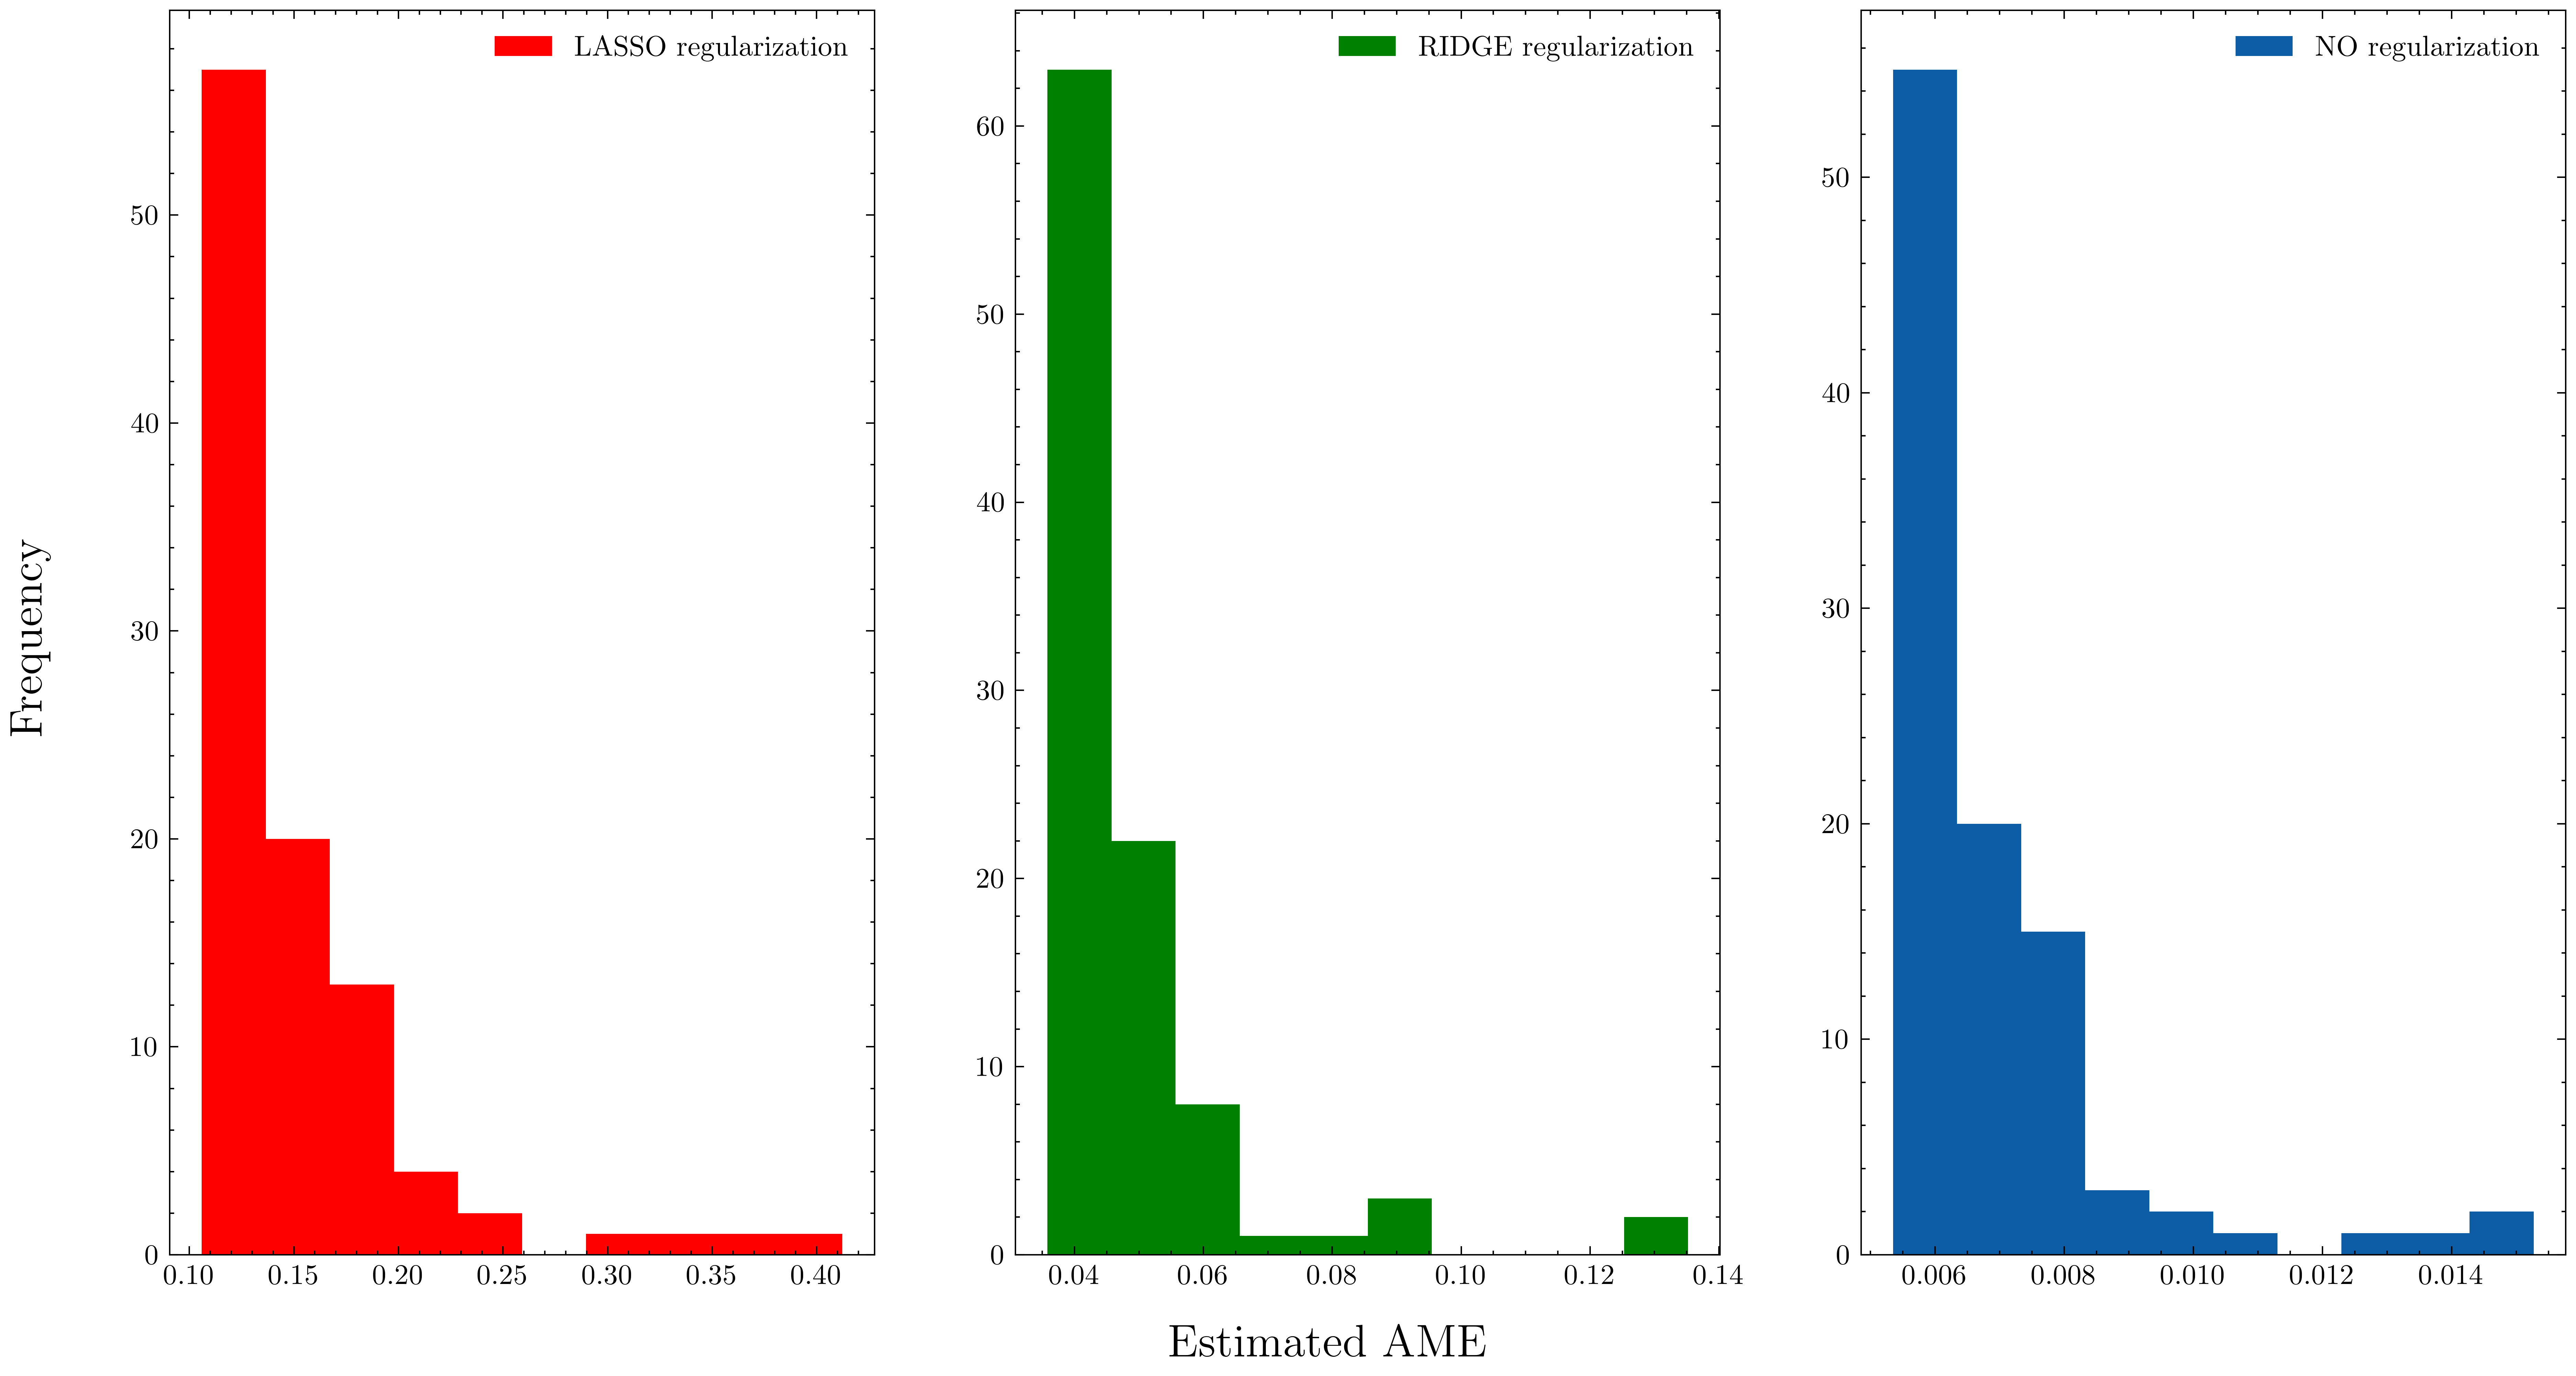

In [7]:
#Prepare data for plot
l1plot = l1res.margins.melt(id_vars=["token"])
l2plot = l2res.margins.melt(id_vars=["token"])
noneplot = noregres.margins.melt(id_vars=["token"])

#Plot distribution of 100 largest AMEs under different regularization
with plt.style.context(['science']):
    fig, axs = plt.subplots(1,3, figsize=(15,8), dpi = 600)
    axs[0].hist(l1plot["value"].sort_values(ascending=False).head(100), color = "r", label = "LASSO regularization")
    axs[0].legend()
    axs[1].hist(l2plot["value"].sort_values(ascending=False).head(100), color = "g", label = "RIDGE regularization")
    axs[1].legend()
    axs[2].hist(noneplot["value"].sort_values(ascending=False).head(100), label = "NO regularization")
    axs[2].legend()
    fig.text(0.5,0.07, r"Estimated AME", ha="center", va="center", size = 16)
    fig.text(0.08,0.5, "Frequency", ha="center", va="center", rotation=90, size = 16)
    plt.savefig("ame_plot.pdf")
    plt.show()

Now evaluating the rank-order correlation between the lasso-regularized and non-regularized model top 100 AMEs. To do this we use the non-parametric spearmans correlation coefficient. See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html. 

In [8]:
parties = [ "Australian Greens", "Australian Labor Party", "Liberal Party of Australia","The Nationals"]
        
#define colors and markers
colors_markers = [("#2c9deb", "o-"), ("#2ceb3a", "^-"), ("#f04222", "*-"), 
                  ("#ed48e5", "+-"), ("#FFC300", "*-"), ("#ffb8d0 ", "s-")]

In [9]:
l1res.fitted_model.classes_

array(['Australian Greens', 'Australian Labor Party',
       'Liberal Party of Australia', 'The Nationals'], dtype=object)

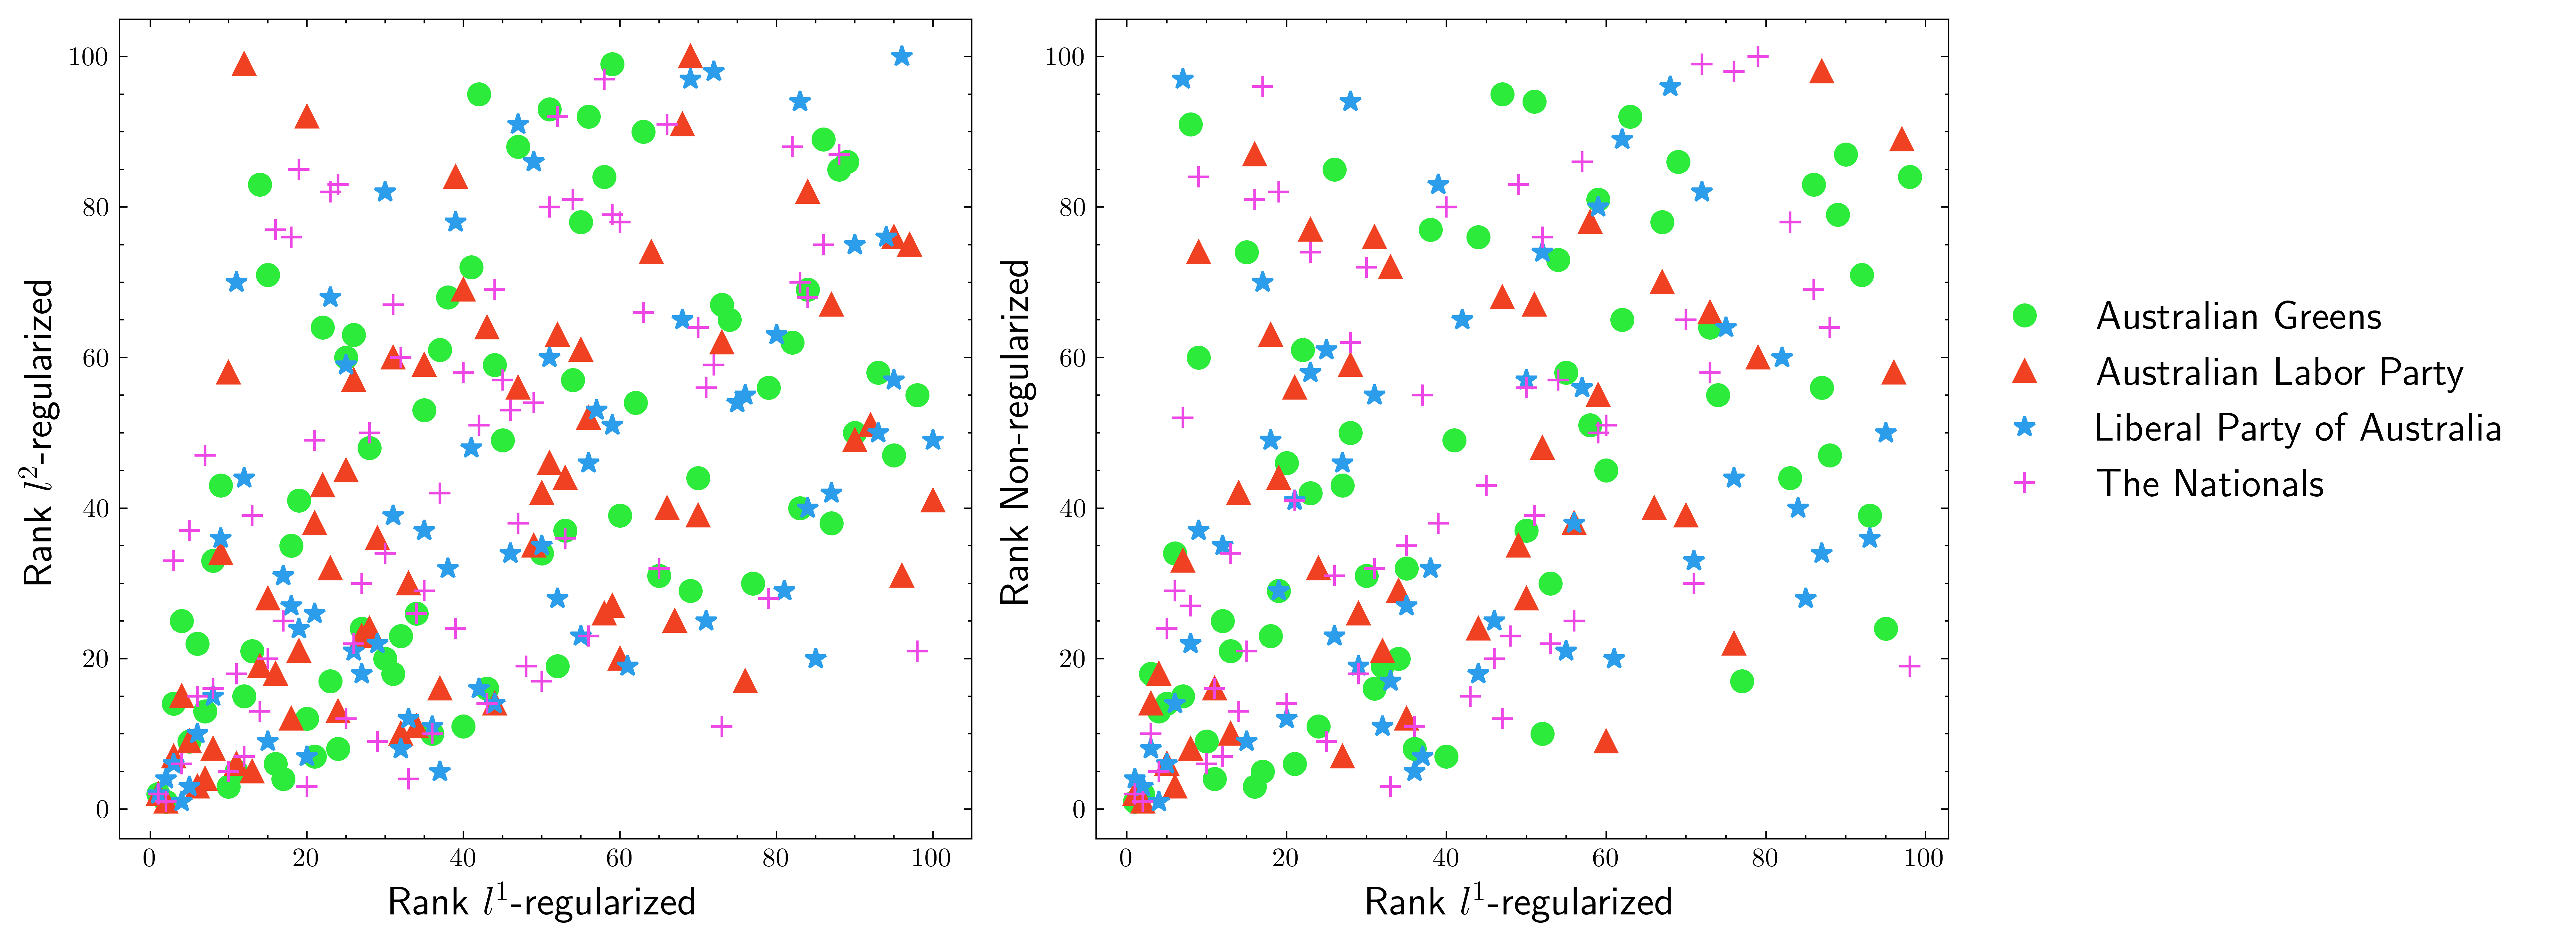

In [10]:
#List for count of AMEs not in the intersection of top 100 from both models
tokens_count = []
rank_corr_lst = []
with plt.style.context(['science']):
    fig, axs = plt.subplots(1,2 , figsize=(13.5,5), dpi = 600)
    colors_markers = [("#2ceb3a", "o"), ("#f04222", "^"), ("#2c9deb", "*"), ("#ed48e5", "+")]
    
    for ax,outcome in zip(axs, [l2res, noregres]):
        rank_corr = {}
        for mark,party in zip(colors_markers,l1res.fitted_model.classes_):
            #Get top 100 AMEs
            x = l1res.margins.sort_values(party, ascending=False).head(100)
            y = outcome.margins.sort_values(party, ascending=False).head(100)

            #Add the rank of each token
            x["rank"] = [r+1 for r in range(x.shape[0])]
            y["rank"] = [r+1 for r in range(y.shape[0])]

            #Df containing intersect of x and y
            rank_df = x.merge(y, on="token")

            #Append the amount of tokens not in both top 100 AMEs
            tokens_count.append(rank_df.shape[0])

            #calculate correlation between rank
            rank_corr[party] = spearmanr(rank_df["rank_x"], rank_df["rank_y"])

            ax.plot(rank_df["rank_x"], rank_df["rank_y"], marker = mark[1], color = mark[0], label = party,
                   linestyle = "none", markersize = 8)

        rank_corr_lst.append(rank_corr)
        
        ax.set_xlabel(r"Rank $l^1$-regularized", size = 15)
        if outcome == l2res:
            ax.set_ylabel(r"Rank $l^2$-regularized", size = 15)
        else:
            ax.set_ylabel(r"Rank Non-regularized", size = 15)
        
    ax.legend(bbox_to_anchor=(1, 0.7), fontsize = 15)
    fig.tight_layout()
    plt.savefig("rank_corr.pdf")

In [11]:
corr_df1 = pd.DataFrame(rank_corr_lst[0]).transpose().reset_index()
corr_df1.columns = ["party", "spearmans-r", "p-value"]
corr_df1["token_count"] = tokens_count[:4]
corr_df1.round(2)

,party,spearmans-r,p-value,token_count
0,Australian Greens,0.57,0.0,73
1,Australian Labor Party,0.56,0.0,65
2,Liberal Party of Australia,0.57,0.0,62
3,The Nationals,0.47,0.0,68


In [12]:
corr_df2 = pd.DataFrame(rank_corr_lst[1]).transpose().reset_index()
corr_df2.columns = ["party", "spearmans-r", "p-value"]
corr_df2["token_count"] = tokens_count[4:]
corr_df2.round(2)

,party,spearmans-r,p-value,token_count
0,Australian Greens,0.53,0.0,63
1,Australian Labor Party,0.48,0.0,45
2,Liberal Party of Australia,0.40,0.0,52
3,The Nationals,0.46,0.0,58
